In [2]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers 
from lightgbm import LGBMClassifier
import lightgbm

# Analysis libs
from itertools import cycle
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif

In [3]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [4]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Category
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [5]:
X.shape

(58596, 50)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [8]:
# lgbm = LGBMClassifier(n_estimators=X.shape[1], learning_rate=1.0)
lgbm = LGBMClassifier(n_estimators=X.shape[1], learning_rate=1.0)
clf = lgbm.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print('Train score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))
print('Test accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7614
[LightGBM] [Info] Number of data points in the train set: 41017, number of used features: 50
[LightGBM] [Info] Start training from score -0.693172
[LightGBM] [Info] Start training from score -1.789154
[LightGBM] [Info] Start training from score -1.766078
[LightGBM] [Info] Start training from score -1.820724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [9]:
cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
cm

array([[8724,    4,   61,    1],
       [  59, 1651,  657,  570],
       [ 104,  458, 2061,  383],
       [  37,  731,  482, 1596]])

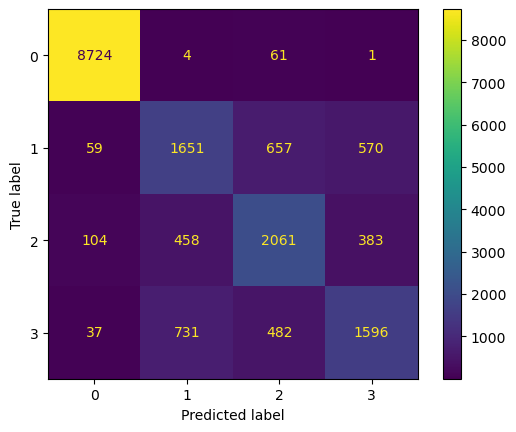

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [11]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8790
           1       0.58      0.56      0.57      2937
           2       0.63      0.69      0.66      3006
           3       0.63      0.56      0.59      2846

    accuracy                           0.80     17579
   macro avg       0.70      0.70      0.70     17579
weighted avg       0.80      0.80      0.80     17579



In [12]:
train_data = lightgbm.Dataset(X_train, label=y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'verbose': -1
}

cv_results = lightgbm.cv(params, train_data, num_boost_round=100, nfold=10, stratified=True)

print(f"Average Log Loss: {cv_results['valid multi_logloss-mean'][-1]:.4f} +/- {cv_results['valid multi_logloss-stdv'][-1]:.4f}")


Average Log Loss: 0.3214 +/- 0.0080


[LightGBM] [Info] Number of positive: 23508, number of negative: 23368
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7641
[LightGBM] [Info] Number of data points in the train set: 46876, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501493 -> initscore=0.005973
[LightGBM] [Info] Start training from score 0.005973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

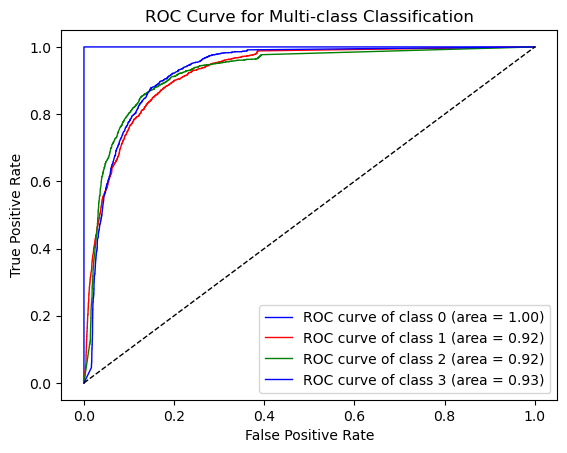

In [14]:
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]


X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

classifier = OneVsRestClassifier(LGBMClassifier(n_estimators=X.shape[1], learning_rate=1.0))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()